# Importing Relevant Libraries

In [82]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../input"))

['test-fabric', 'testing']


# Defining Constants

In [83]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Preprocessing Traning Data

In [84]:
filenames = os.listdir("../input/test-fabric")
categories = []
for filename in filenames:
    category = filename.split('0')[0]
    if category == 'defected':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [85]:
df.head()

,filename,category
0,defected00132.jpg,1
1,notDefected00109.png,0
2,defected00079.jpg,1
3,defected00107.jpg,1
4,notDefected00036.png,0


In [86]:
df.tail()

,filename,category
539,notDefected00129.png,0
540,notDefected00142.png,0
541,defected00221.jpg,1
542,defected00245.jpg,1
543,defected00105.jpg,1


### See Total In count
### 0 => Not Defected | 1 => Defected

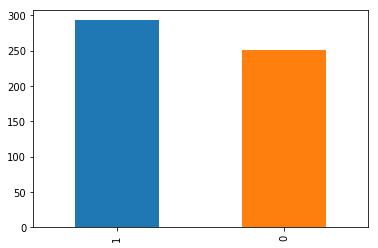

In [87]:
df['category'].value_counts().plot.bar()

# See sample image

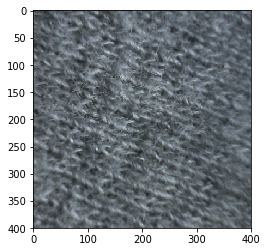

In [88]:
sample = random.choice(filenames)
image = load_img("../input/test-fabric/"+sample)
plt.imshow(image)

# Build Model

<img src="https://i.imgur.com/qE0OYRz.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example the fabric image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layer will reduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [148]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have NOT-DEFECTED and DEFECTED classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_21 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_22 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 30, 30, 64)        0         
__________

# Callbacks

In [149]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [150]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [151]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [152]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to DEFECTED and 0 to NOT-DEFECTED

In [153]:
df["category"] = df["category"].replace({0: 'not-defected', 1: 'defected'}) 

In [154]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

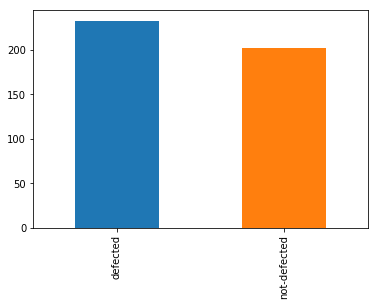

In [155]:
train_df['category'].value_counts().plot.bar()

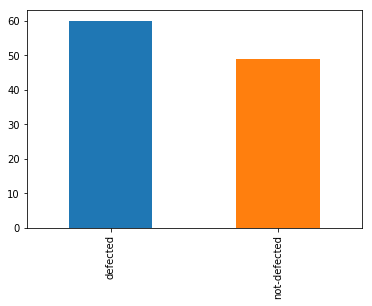

In [156]:
validate_df['category'].value_counts().plot.bar()

In [157]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Training Image Generator

In [158]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../input/test-fabric/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 434 images belonging to 2 classes.


### Validation Generator

In [159]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../input/test-fabric/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 109 images belonging to 2 classes.


# See how our Generator Works

In [160]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../input/test-fabric", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 images belonging to 1 classes.


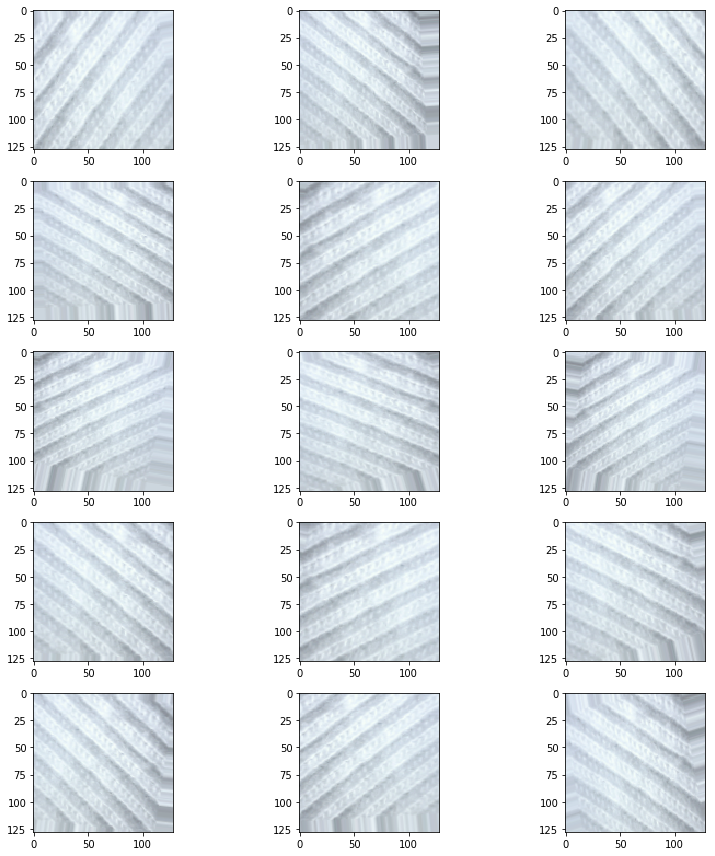

In [161]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [162]:
epochs=3 if FAST_RUN else 15
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/15
29/29 [==============================] - 6s 216ms/step - loss: 1.5769 - acc: 0.5972 - val_loss: 1.3843 - val_acc: 0.6762
Epoch 2/15
29/29 [==============================] - 4s 132ms/step - loss: 1.0068 - acc: 0.5897 - val_loss: 1.2400 - val_acc: 0.5957
Epoch 3/15
29/29 [==============================] - 4s 145ms/step - loss: 0.9496 - acc: 0.6110 - val_loss: 0.9206 - val_acc: 0.7660
Epoch 4/15
29/29 [==============================] - 4s 154ms/step - loss: 0.9088 - acc: 0.6154 - val_loss: 0.6437 - val_acc: 0.7128
Epoch 5/15
29/29 [==============================] - 4s 154ms/step - loss: 0.9092 - acc: 0.6245 - val_loss: 0.5908 - val_acc: 0.7128

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/15
29/29 [==============================] - 4s 126ms/step - loss: 0.7197 - acc: 0.6639 - val_loss: 0.9097 - val_acc: 0.7340
Epoch 7/15
29/29 [==============================] - 4s 143ms/step - loss: 0.7696 - acc: 0.6686 - val_loss: 0.6085 - val_acc: 0.

# Save Model

In [163]:
model.save_weights("model.h5")

# Visualize Training

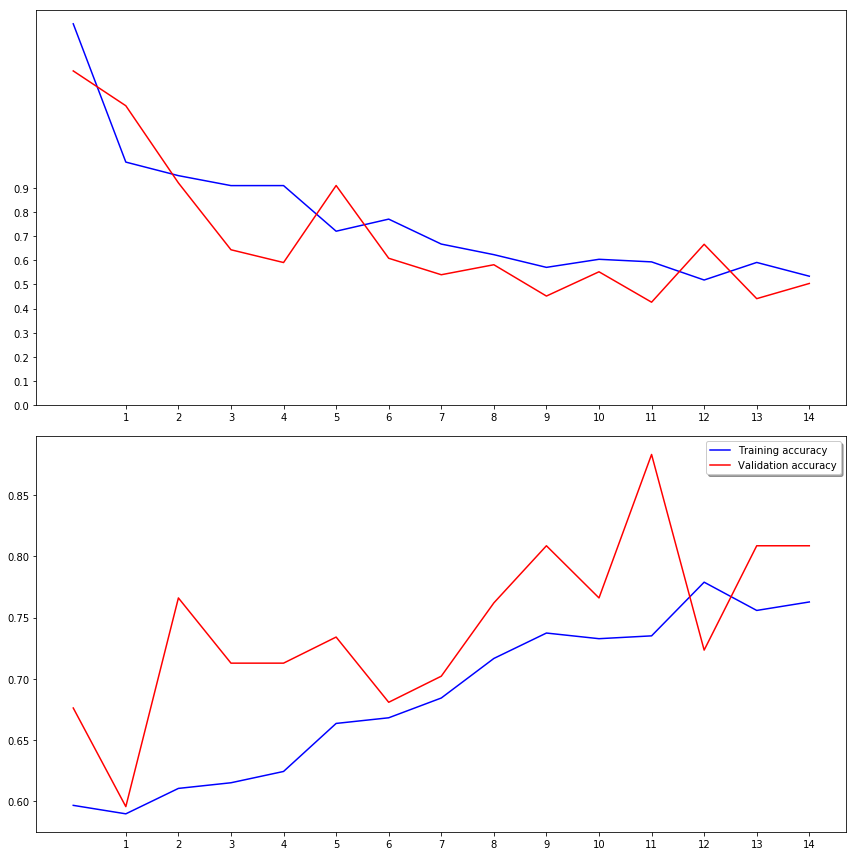

In [164]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [165]:
test_filenames = os.listdir("../input/testing/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [166]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/testing/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 45 images.


# Predict

In [167]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [168]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [169]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'defected', 0: 'not-defected'}`. Now we will map the result back to defected is 1 and not-defected is 0

In [170]:
test_df['category'] = test_df['category'].replace({'defected':1, 'not-defected':0})

In [171]:
test_df

,filename,category
0,notDefected00002.png,0
1,defected00007.png,1
2,defected00024.jpg,1
3,defected00018.jpg,1
4,defected00017.jpg,1
5,notDefected00004.png,0
6,notDefected00012.png,0
7,notDefected00007.png,0
8,defected00028.jpg,1
9,notDefected00014.png,0


### Visualize Result

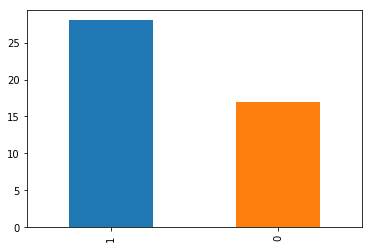

In [172]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

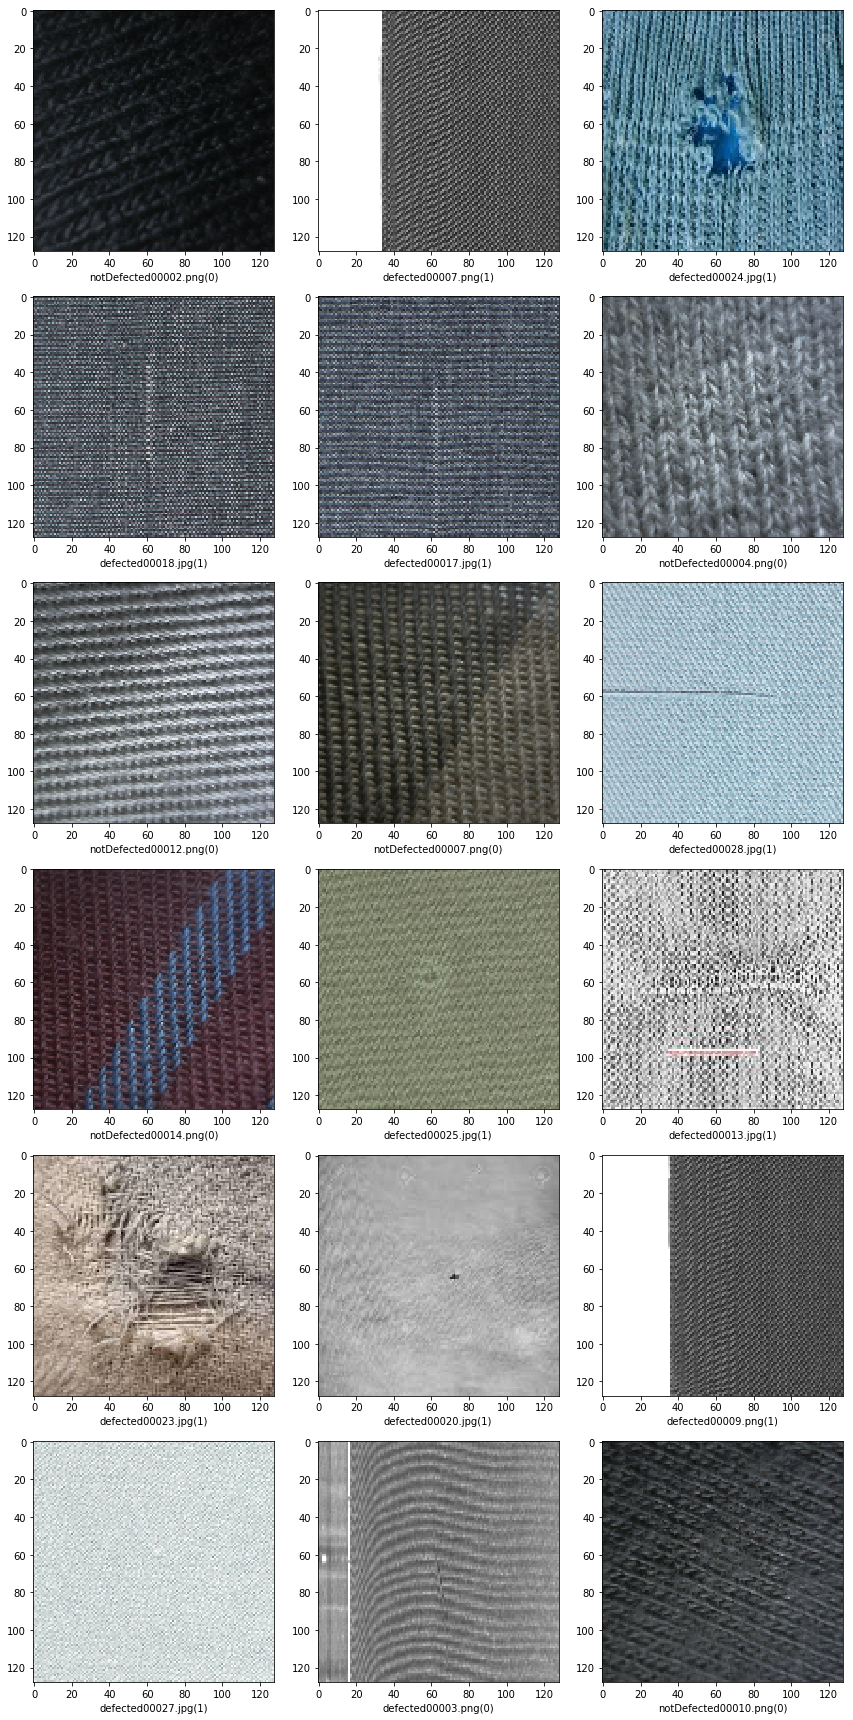

In [173]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../input/testing/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

> # Predictions

In [174]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('predictions.csv', index=False)